In [9]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from IPython import display
import argparse
import logging
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import tsfresh
from tsfresh.feature_extraction import MinimalFCParameters
from os.path import exists

In [10]:
## FUNCTIONS ##

#Parse String
def split_ele(x):
    a = np.array(re.findall(r"[-+]?\d*\.?\d+|[-+]?\d+", x))
    return a.astype(float)

def get_args():
    parser = argparse.ArgumentParser(description='Recommendations for the given song')
    parser.add_argument('-s', '--song', required=True, help='Name of Song')
    parser.add_argument('-a', '--artist', required=True, help='Name of Artist')
    return parser.parse_args()


def get_song(name_song, name_artist):
    results = sp.search(q=name_song + ' '+name_artist, type='track')
    items = results['tracks']['items']
    if len(items) > 0:
        return items[0]
    else:
        return None

def show_recommendations_for_song(song):
    results = sp.recommendations(seed_tracks=[song['id']], limit=5)
    print("Recommendations:")
    for track in results['tracks']:
        print("TRACK: ",track['name'], " - ",track['artists'][0]['name'])
        sp.add_to_queue(track['uri'])

def show_feature_based_recommendations_for_song(song):
    song_features = sp.audio_features([song['uri']])
    kwargs = {"target_danceability":song_features[0]["danceability"], "target_energy":song_features[0]['energy'], 
              "target_key":song_features[0]['key'], "target_loudness":song_features[0]['loudness'], 
              "target_speechiness":song_features[0]['speechiness'], 
              "target_acousticness":song_features[0]['acousticness'], 
              "target_instrumentalness":song_features[0]['instrumentalness'], 
              "target_liveness":song_features[0]['liveness'], "target_valence":song_features[0]['valence'], 
              "target_tempo":song_features[0]['tempo'], "target_time_signature":song_features[0]['time_signature']}
    results = sp.recommendations(seed_artists=None, seed_genres=None, seed_tracks=[song['id']], limit=5, country=None, **kwargs)
    print("Feature-based Recommendations:")
    for track in results['tracks']:
        print("TRACK: ",track['name'], " - ",track['artists'][0]['name'])
        sp.add_to_queue(track['uri'])


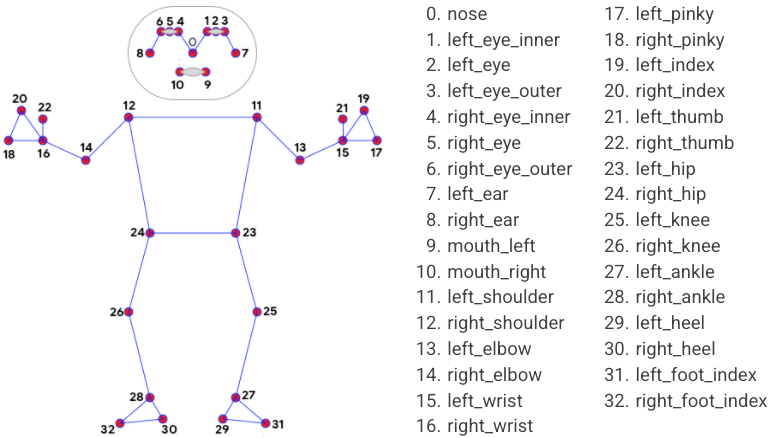

In [11]:
# READ IN FILE ##

pose_landmark = ['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER', 'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER', 'LEFT_EAR', 'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT',
              'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW', 'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX', 'LEFT_THUMB',
              'RIGHT_THUMB', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL', 'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX']
display.Image("./pose_tracking_full_body_landmarks.png")

# EXTRACT FEATURES

In [12]:
song_name_list = ['love_girl', 'party_rock_anthem', 'lite_spots', 'girlfriends_best_friend', 'scaredy_cat', 
                  'girl_anachronism', 'lil_darlin', 'el_invento', 'test_drive', 'weight_in_gold', 'easy', 'comethru', 
                  'classic', 'tongue_tied', 'motley', 'knife_talk', 'feed_the_fire', 'lose_it', 'thats_what_i_like', 
                  'humble', 'skeletons', 'stairway_to_heaven', 'slow_dancing_in_the_dark', 'peaches', 'kilby_girl', 
                  'jupiter_love', 'woman', 'get_up', 'throwin_elbows', 'power', 'ymca']
artist_name_list = ['cnblue', 'lmfao', 'kaytranada', 'walkabout', 'dpr_ian', 'the_dresden_dolls', 'count_basie', 
                    'jose_gonzalez_calvaire', 'ariana_grande', 'gallant', 'wheein', 'jeremy_zucker', 'mkto', 
                    'grouplove', 'post_malone', 'drake', 'lucky_daye', 'swmrs', 'bruno_mars', 'kendrick_lamar', 
                    'keshi', 'led_zeppelin', 'joji', 'justin_bieber', 'backseat_lovers', 'trey_songz', 'doja_cat', 
                    'ciara', 'excision', 'little mix', 'village_people']
num_runs = 2
num_splits = 3

In [15]:
# Spotify Song Features
def get_audio_features(song_name, artist_name):

    song = get_song(song_name, artist_name)

    #if get request didnt get anything
    if(song is None):
        return None

    song_features = sp.audio_features([song['uri']])

    audio_feature_list = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                          'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

    audio_feat = pd.DataFrame(columns = audio_feature_list, index = range(1, 2))

    audio_feat['danceability'] = song_features[0].get('danceability')
    audio_feat['energy'] = song_features[0].get('energy')
    audio_feat['key'] = song_features[0].get('key')
    audio_feat['loudness'] = song_features[0].get('loudness')
    audio_feat['mode'] = song_features[0].get('mode')
    audio_feat['speechiness'] = song_features[0].get('speechiness')
    audio_feat['acousticness'] = song_features[0].get('acousticness')
    audio_feat['instrumentalness'] = song_features[0].get('instrumentalness')
    audio_feat['liveness'] = song_features[0].get('liveness')
    audio_feat['valence'] = song_features[0].get('valence')
    audio_feat['tempo'] = song_features[0].get('tempo')
    audio_feat['time_signature'] = song_features[0].get('time_signature')

    return audio_feat

# Checks if a file exists
# Used before pulling spotify audio features and going through each split's time series
def file_exists(file_num, song_name, artist_name, split_num=0):
    x_file_name = f'preprocessed/{file_num}_{split_num}_{song_name}_{artist_name}_XDATA.csv'
    y_file_name = f'preprocessed/{file_num}_{split_num}_{song_name}_{artist_name}_YDATA.csv'
    
    #if file does not exist, skip it
    if(exists(x_file_name) and exists(y_file_name)):
        return True
    else:
        return False

# Extracting movement time series features
def splits_feature_set(file_num, split_num, song_name, artist_name):

    x_file_name = f'preprocessed/{file_num}_{split_num}_{song_name}_{artist_name}_XDATA.csv'
    y_file_name = f'preprocessed/{file_num}_{split_num}_{song_name}_{artist_name}_YDATA.csv'

    # if file does not exist, skip it
    if(exists(x_file_name) and exists(y_file_name)):
        num_features = 10
        num_nodes = 14
        num_samples = 10

        df_columns = ['LEFT_EYE_OUTER_POS', 'LEFT_EYE_OUTER_DIST', 'RIGHT_EYE_OUTER_POS', 'RIGHT_EYE_OUTER_DIST', 
            'LEFT_SHOULDER_POS', 'LEFT_SHOULDER_DIST', 'RIGHT_SHOULDER_POS', 'RIGHT_SHOULDER_DIST', 'LEFT_ELBOW_POS', 
            'LEFT_ELBOW_DIST', 'RIGHT_ELBOW_POS', 'RIGHT_ELBOW_DIST', 'LEFT_WRIST_POS', 'LEFT_WRIST_DIST', 
            'RIGHT_WRIST_POS', 'RIGHT_WRIST_DIST', 'LEFT_HIP_POS', 'LEFT_HIP_DIST', 'RIGHT_HIP_POS', 'RIGHT_HIP_DIST', 
            'LEFT_KNEE_POS', 'LEFT_KNEE_DIST', 'RIGHT_KNEE_POS', 'RIGHT_KNEE_DIST', 'LEFT_ANKLE_POS', 
            'LEFT_ANKLE_DIST', 'RIGHT_ANKLE_POS', 'RIGHT_ANKLE_DIST']

        #LOAD IN DATA
        x_data = pd.read_csv(x_file_name, sep = ',')
        y_data = pd.read_csv(y_file_name, sep = ',')

        #MOTION FEATURE EXTRACTION
        curr_extracted_vector = pd.DataFrame()

        #LOOP THROUGH NODES
        for col in df_columns:
            col_x = x_data[col]
            col_y = y_data[col]

            #Every Node (Body Part) has this set of feaures

            xname = col + "_x"
            yname = col + "_y"
            
            # Timeseries features to extract
            # TODO: tune parameters for autocorrelation, approximate_entropy, c3, cid_ce
            settings = {
                xname: {
                    "abs_energy": None, 
                    "kurtosis": None, 
                    "mean": None, 
                    "standard_deviation": None, 
                    "maximum": None,
                    "autocorrelation": [{"lag": 1}],
                    "approximate_entropy": [{"m": 20, "r": 0.05}],
                    "c3": [{"lag": 1}],
                    "cid_ce": [{"normalize": True}]
                }, 
                yname: {
                    "abs_energy": None, 
                    "kurtosis": None, 
                    "mean": None, 
                    "standard_deviation": None, 
                    "maximum": None,
                    "autocorrelation": [{"lag": 1}],
                    "approximate_entropy": [{"m": 20, "r": 0.05}],
                    "c3": [{"lag": 1}],
                    "cid_ce": [{"normalize": True}]
                }
            }

            comb = pd.DataFrame(data=[col_x, col_y], index=[xname, yname]).T
            comb.rename_axis("time")
            comb["id"] = 1
            comb["time"] = comb.index

            curr_extracted = tsfresh.extract_features(comb, column_id = "id", column_sort="time", 
                                                      column_kind=None, column_value=None, 
                                                      kind_to_fc_parameters=settings, disable_progressbar=True)
            curr_extracted_vector = pd.concat([curr_extracted_vector, curr_extracted], axis=1)

            # TODO (optional) append frequency info (max frequency, variance of frequency content, etc) 
            # using scipy.signal.spectrogram and argmax, std, etc. of the spectrogram
                        
        return curr_extracted_vector
    return None


In [16]:
extracted_features = pd.DataFrame()

# Instantiate Spotify Client
logger = logging.getLogger()
logging.basicConfig()
CLIENT_ID="9793440f0a5047c59c70bcfcf91ad589"
CLIENT_SECRET= "b66dc3a5f9f34207bebee32a25745368"
REDIRECT_URL="http://localhost/"
client_credentials_manager = SpotifyClientCredentials(client_id = CLIENT_ID, client_secret = CLIENT_SECRET)
oAuth = SpotifyOAuth(client_id = CLIENT_ID, client_secret = CLIENT_SECRET, redirect_uri = REDIRECT_URL, scope = 'user-modify-playback-state')
sp = spotipy.Spotify(auth_manager =oAuth)


# Extract all features
# Goes through each run, each song, and each split
for file_num in range(1, num_runs+1):
    for index in range(len(song_name_list)):
        
        song_name = song_name_list[index]
        artist_name = artist_name_list[index]
        
        if file_exists(file_num, song_name, artist_name):
            audio_feat = get_audio_features(song_name, artist_name)

            for split_num in range(num_splits):
                
                curr_extracted_vector = splits_feature_set(file_num, split_num, song_name, artist_name)
                
                if not curr_extracted_vector.empty:
                    curr_extracted_vector = pd.concat([curr_extracted_vector, audio_feat], axis=1)
                    extracted_features = extracted_features.append(curr_extracted_vector)


In [18]:
extracted_features.to_csv("parser_output/extracted_features_split.csv")

In [17]:
extracted_features

,LEFT_EYE_OUTER_POS_x__abs_energy,LEFT_EYE_OUTER_POS_x__kurtosis,LEFT_EYE_OUTER_POS_x__mean,LEFT_EYE_OUTER_POS_x__standard_deviation,LEFT_EYE_OUTER_POS_x__maximum,LEFT_EYE_OUTER_POS_x__autocorrelation__lag_1,LEFT_EYE_OUTER_POS_x__approximate_entropy__m_20__r_0.05,LEFT_EYE_OUTER_POS_x__c3__lag_1,LEFT_EYE_OUTER_POS_x__cid_ce__normalize_True,LEFT_EYE_OUTER_POS_y__abs_energy,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
1,3.857886e+06,-0.500597,229.468110,30.432529,289.405029,0.989740,0.019048,1.261402e+07,1.356488,2.502215e+06,...,1.0,-11.683,1.0,0.4710,0.034600,0.069800,0.1120,0.394,120.461,4.0
1,3.855130e+06,-0.483415,231.389670,27.503200,295.279053,0.958905,0.019418,1.296885e+07,2.453771,2.669921e+06,...,1.0,-11.683,1.0,0.4710,0.034600,0.069800,0.1120,0.394,120.461,4.0
1,2.988295e+06,-1.564327,204.247290,19.279543,231.353989,0.984248,0.019418,8.737854e+06,1.356007,2.048704e+06,...,1.0,-11.683,1.0,0.4710,0.034600,0.069800,0.1120,0.394,120.461,4.0
1,5.229781e+06,5.505027,261.979358,13.406352,288.362549,0.740990,0.017700,1.824470e+07,4.185149,2.621451e+06,...,1.0,-4.961,1.0,0.0406,0.013000,0.000000,0.0944,0.860,134.066,4.0
1,3.804110e+06,-1.651266,221.742280,29.739429,267.973663,0.980201,0.017700,1.132808e+07,1.264870,2.240099e+06,...,1.0,-4.961,1.0,0.0406,0.013000,0.000000,0.0944,0.860,134.066,4.0
1,4.901618e+06,-0.745672,254.560648,23.532701,296.069458,0.957763,0.018019,1.697213e+07,2.085975,2.669213e+06,...,1.0,-4.961,1.0,0.0406,0.013000,0.000000,0.0944,0.860,134.066,4.0
1,4.660389e+06,-0.427668,233.305676,19.914044,268.653778,0.958823,0.015267,1.295362e+07,2.823341,2.897256e+06,...,1.0,-6.638,0.0,0.1020,0.000282,0.000054,0.0958,0.421,150.011,4.0
1,5.928069e+06,-1.698999,262.463987,29.234369,307.102661,0.991668,0.015267,1.873346e+07,1.487862,2.845367e+06,...,1.0,-6.638,0.0,0.1020,0.000282,0.000054,0.0958,0.421,150.011,4.0
1,6.406707e+06,-0.398214,275.922853,11.700681,303.604675,0.960919,0.015504,2.105558e+07,2.539979,2.516463e+06,...,1.0,-6.638,0.0,0.1020,0.000282,0.000054,0.0958,0.421,150.011,4.0
1,3.246851e+06,-0.599519,216.781275,27.453500,276.754089,0.956300,0.020619,1.060912e+07,1.998027,2.938563e+06,...,2.0,-12.782,1.0,0.0754,0.296000,0.086500,0.1080,0.273,80.021,4.0
